#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import math

In [2]:
np.random.seed(1402)

n_sim = 1000
n_samples = 100
k_att = 100

Then, define utility functions for simulating data and calculating the test statistics:


In [3]:
def synthesize(population_prob, n=1):
    l = len(population_prob)
    size = (n, l)
    return np.random.binomial(n=1, p=population_prob, size=size)

###################################################################################################

def test_homer(alice, sample_mean, population_mean):
    return sum(abs(alice - population_mean) - abs(alice - sample_mean))

###################################################################################################

def test_dwork(alice, sample_mean, population_mean):
    return sum((alice-population_mean) *  (sample_mean-population_mean)) 

###################################################################################################

def null_distribution(funny, population_prob, population_mean, null_sims=1000, alpha=0.05):
    
    acc = []

    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
    
        f = funny(null_alice, sample_mean, population_mean)
        acc.append(f)

    ### Descending sort
    null_dist_vals = np.sort(acc)[::-1]
    critical_vals = null_dist_vals[round(alpha * null_sims)]
    
    return null_dist_vals, critical_vals

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [4]:
def show_distribution(x, critical_value, title):
    
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)

    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='g')
    plt.fill_between(support[~flag], densities[~flag], color='b')
    plt.axvline(x=critical_value)
    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

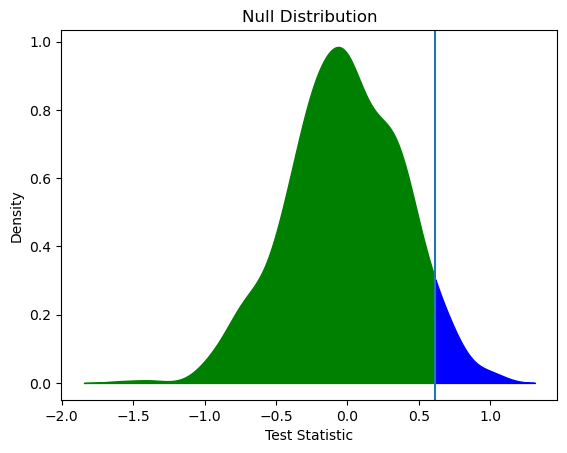

In [5]:
population_prob = np.random.uniform(size=k_att)
population_mean = population_prob 

null_dist = null_distribution(test_homer, population_prob, population_mean)
show_distribution(null_dist[0], null_dist[1], title="Null Distribution")
plt.show()

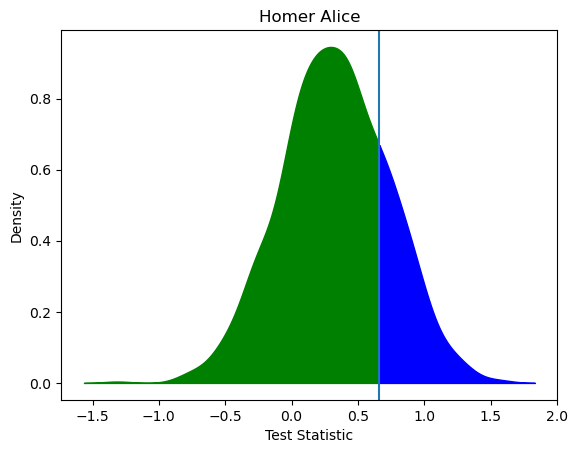

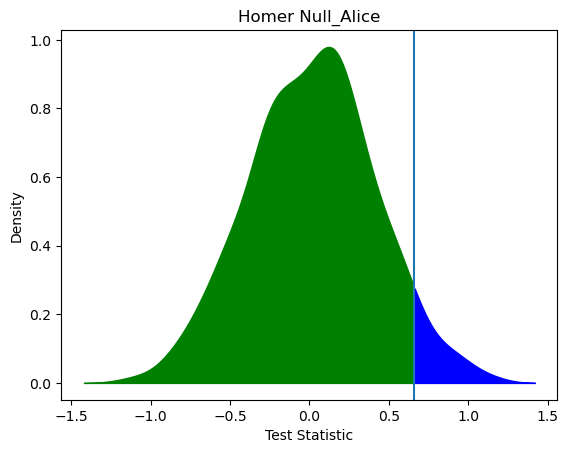

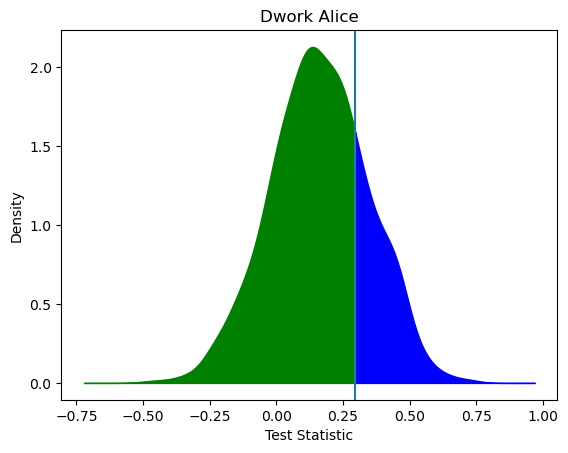

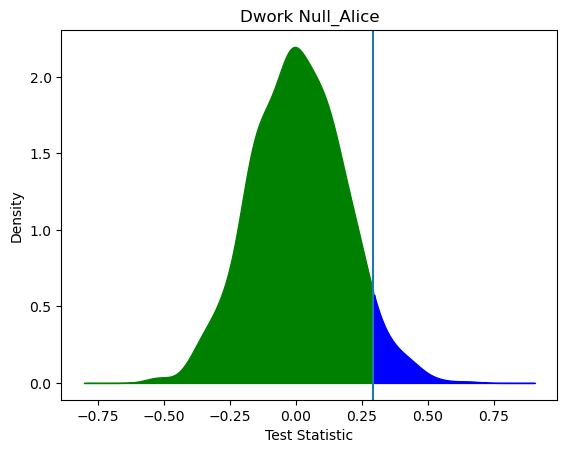

In [6]:
history = np.zeros((n_sim, 4))

alpha = 0.05

nulldist_homer = null_distribution(test_homer, population_prob, population_mean, alpha=alpha)
nulldist_dwork = null_distribution(test_dwork, population_prob, population_mean, alpha=alpha)

for i in range(n_sim):

    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(population_prob, n=1)[0]

    history[i, :] = [

        test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean), 

        test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)
                    ]

show_distribution(history[:, 0], critical_value=nulldist_homer[1], title="Homer Alice")
show_distribution(history[:, 1], critical_value=nulldist_homer[1], title="Homer Null_Alice")

show_distribution(history[:, 2], critical_value=nulldist_dwork[1], title="Dwork Alice")
show_distribution(history[:, 3], critical_value=nulldist_dwork[1], title="Dwork Null_Alice")

# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [7]:
def laplace(loc, scale, size=None):
    return np.random.laplace(loc, scale, size)

######################################################

def clamp(x, bounds):  
    
    # bounds=(lower, upper) ex.(10, 60)
    lower = bounds[0]
    upper = bounds[1] 
    
    return np.clip(x, lower, upper)

######################################################

def bounded_mean(x, bounds): 
    return np.mean(clamp(x, bounds))

######################################################

def release_dp_mean_laplace(x, epsilon, bounds):
    
    n = len(x)
    
    lower = bounds[0]
    upper = bounds[1] 
     
    sensitivity = (upper-lower)/n
    scale = sensitivity / epsilon
    
    sens_answer = bounded_mean(x, bounds)
    dp_mean = sens_answer + laplace(0, scale)
    
    return dp_mean

Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [8]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
education_bounds = (1, 16) # 16 point scale
educ = data['educ'].values
print(release_dp_mean_laplace(educ, bounds=education_bounds, epsilon=0.2))

10.609578856404056


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [9]:
def release_histogram(x, epsilon, categories):
    sensitivity = 1
    scale = sensitivity/epsilon

    z = zip(*np.unique(x, return_counts=True))
    count = dict(z)
    
    sensitive_histogram = []
    
    for i in categories:
        sensitive_histogram.append(np.array([count.get(i)]))

    dp_histogram = sensitive_histogram + laplace(loc=0, scale=scale, size=1)
    return dp_histogram[:, 0]


data_points = list(range(1, 17))
output = release_histogram(educ, epsilon=0.2, categories=data_points)

print(output)

[ 276.04510583  145.04510583  361.04510583  473.04510583  501.04510583
  761.04510583  898.04510583 1064.04510583 5151.04510583 1400.04510583
 3968.04510583 1159.04510583 6288.04510583 2273.04510583  799.04510583
  313.04510583]


Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [11]:
def bootstrap(x, n):
    m = max(x)
    return np.random.choice(m, n)

##################################################################################

n_simulation = 1000

log_sequence = np.linspace(start=math.log10(200), stop=math.log10(2000), num=20)
n_seq = (10**log_sequence).astype(int)
print(n_seq)


log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=10)
epsilon_sequence = (10**log_seq *100).astype(int)/100
print(epsilon_sequence)

history_array = []
c = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(epsilon_sequence):
        sq_error = 0

        for k in range(n_simulation):
            bootdata = bootstrap(educ, n_simulation)
            sensitive_mean = bounded_mean(x=bootdata, bounds=education_bounds)
            dp_mean = release_dp_mean_laplace(x=bootdata, bounds=education_bounds, epsilon=epsilon_sim)
            sq_error += (dp_mean - sensitive_mean) ** 2

        history_array.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error/n_simulation)  
        ])
        
        c += 1

history_array = pd.DataFrame(history_array, columns=["N", "epsilon", "error"])

[ 200  225  254  287  324  366  413  467  527  595  671  758  856  966
 1091 1231 1390 1569 1771 2000]
[1.   0.77 0.59 0.46 0.35 0.27 0.21 0.16 0.12 0.1 ]


In [12]:
history_array

,N,epsilon,error
0,200,1.00,0.021399
1,200,0.77,0.028997
2,200,0.59,0.039662
3,200,0.46,0.049046
4,200,0.35,0.057562
...,...,...,...
195,2000,0.27,0.081077
196,2000,0.21,0.097548
197,2000,0.16,0.137377
198,2000,0.12,0.171775


Now graph your resluts!

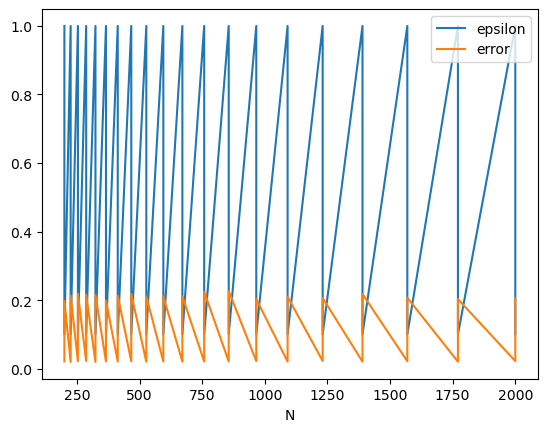

In [15]:
history_array.plot('N');

# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [ ]:
from opendp import *
from opendp.mod import enable_features
import opendp.prelude as dp
from opendp.mod import enable_features, Transformation, Measurement
from opendp.trans import make_clamp, make_bounded_resize, make_sized_bounded_mean

enable_features('contrib')

In [ ]:
import opendp.prelude as dp
enable_features('contrib')

base_laplace = dp.m.make_base_laplace(
    dp.atom_domain(T=float),
    dp.absolute_distance(T=float),
    scale=5.
)
base_laplace(arg=10.)

In [ ]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
education_bounds = (1, 16) # 16 point scale
educ = data['educ'].values

sized_bounded_mean = dp.t.make_size_bounded_mean(size=n, bounds=education_bounds)

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [ ]:
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [ ]:
base_laplace.check(d_in=.15, d_out=.3)

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [ ]:
base_laplace.check(d_in=.2, d_out=.3)

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [ ]:
base_laplace.check(d_in=.15, d_out=.35), base_laplace.check(d_in=.12, d_out=.3)

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [ ]:
dp_mean.check(d_in=1, d_out=.3)

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [ ]:
help(make_count_by_categories)

In [ ]:
education_categories = list(range(1, 17))
histogram_laplace_noise = (
    make_count_by_categories(categories=education_categories, TOA=float, MO=L1Distance[float]) >>
    make_base_laplace(scale=1., D=VectorDomain[AllDomain[float]])
)
histogram_laplace_noise(educ.astype(np.int32))

In [ ]:
education_categories = list(range(1, 17))
histogram_geometric_noise = (
    make_count_by_categories(categories=education_categories) >>
    make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])
)
histogram_geometric_noise(educ.astype(np.int32))



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [16]:
def gaussian(shift=0., scale=1., size=None):
    return np.random.normal(loc=shift, scale=scale, size=size)

###########################################################################

def clamp(x, bounds):  
    
    # bounds=(lower, upper) ex.(10, 60)
    lower = bounds[0]
    upper = bounds[1] 
    
    return np.clip(x, lower, upper)

###########################################################################

def bounded_mean(x, bounds): 
    return np.mean(clamp(x, bounds))

###########################################################################

def release_dp_mean_gaussian(x, bounds, epsilon, delta=1e-6):

    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower = bounds[0]
    upper = bounds[1] 

    sensitivity = (upper-lower)/n

    scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta)) 
    dp_mean = sensitive_mean + gaussian(scale=scale)

    return dp_mean

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [18]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
education_bounds = (1, 16) # 16 point scale
educ = data['educ'].values
print(release_dp_mean_gaussian(educ, bounds=education_bounds, epsilon=0.2))

10.619158861615308


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [20]:
n_simulation = 1000

n_sequence = np.logspace(start=np.log10(200), stop=np.log10(2000), num=20).astype(int)
print("N sequence", n_sequence)

epsilon_sequence = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.1), num=5), decimals=2)
print("epsilon sequence", epsilon_sequence)

delta = 1e-3

history_array = []

c = 0

for i, n_sim in enumerate(n_sequence):
    for j, epsilon_sim in enumerate(epsilon_sequence):
        sq_error_laplace = sq_error_gaussian = 0

        for k in range(n_simulation):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=education_bounds)
            dp_mean_laplace = release_dp_mean_laplace(x=bootdata, bounds=education_bounds, epsilon=epsilon_sim)
            dp_mean_gaussian = release_dp_mean_gaussian(x=bootdata, bounds=education_bounds, epsilon=epsilon_sim, delta=delta)
            sq_error_laplace += (dp_mean_laplace - sensitive_mean) ** 2
            sq_error_gaussian += (dp_mean_gaussian - sensitive_mean) ** 2

        history_array.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error_laplace/n_simulation), 
            np.sqrt(sq_error_gaussian/n_simulation)   
        ])
        

agg_history = pd.DataFrame(history_array, columns=["N", "epsilon", "laplace error", "gaussian error"])

N sequence [ 200  225  254  287  324  366  413  467  527  595  671  758  856  966
 1091 1231 1390 1569 1771 2000]
epsilon sequence [1.   0.56 0.32 0.18 0.1 ]


In [21]:
agg_history

,N,epsilon,laplace error,gaussian error
0,200,1.00,0.099825,0.295308
1,200,0.56,0.187206,0.537013
2,200,0.32,0.327069,0.926653
3,200,0.18,0.635289,1.586570
4,200,0.10,1.062733,2.979855
...,...,...,...,...
95,2000,1.00,0.010749,0.028091
96,2000,0.56,0.019051,0.053844
97,2000,0.32,0.034732,0.090302
98,2000,0.18,0.061057,0.159990


And Finally Graph your result:

<Axes: xlabel='N'>

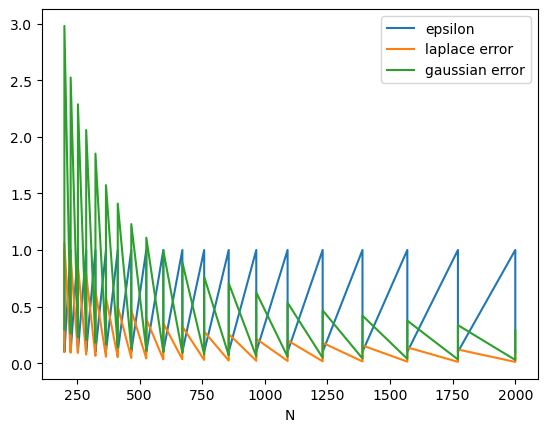

In [22]:
agg_history.plot("N")